# Imports

In [2]:
import pandas as pd
import numpy as np
import json
from random import randrange
import matplotlib.pyplot as plt


# Load Data

In [3]:
df_init = pd.read_parquet('../data/train_2wiki.parquet')

# Quick Pre-Processing
df_init.drop(columns = ['_id', 'type', 'evidences'], axis = 1, inplace=True)
df_init.supporting_facts = df_init.supporting_facts.apply(lambda x: eval(x))
df_init['size_gt'] = df_init.supporting_facts.apply(lambda x: len(x))
df_init['size_gt_doc'] = df_init.supporting_facts.apply(lambda x: len(list(np.unique([elem[0] for elem in x]))))

df_init.head()

,question,context,supporting_facts,answer,size_gt,size_gt_doc
0,Are director of film Move (1970 Film) and dire...,"[[""Stuart Rosenberg"", [""Stuart Rosenberg (Augu...","[[Move (1970 film), 0], [Méditerranée (1963 fi...",no,4,4
1,Do both films The Falcon (Film) and Valentin T...,"[[""The Falcon Takes Over"", [""The Falcon Takes ...","[[The Falcon (film), 0], [Valentin the Good, 0...",no,5,4
2,"Which film whose director is younger, Charge I...","[[""Danger: Diabolik"", [""Danger:"", ""Diabolik i...","[[Charge It to Me, 1], [Danger: Diabolik, 1], ...",Danger: Diabolik,4,4
3,What is the date of birth of Mina Gerhardsen's...,"[[""Pamela Jain"", [""Pamela Jain is an Indian pl...","[[Mina Gerhardsen, 1], [Rune Gerhardsen, 0]]",13 June 1946,2,2
4,What nationality is the director of film Weddi...,"[[""Weekend in Paradise (1931 film)"", [""Weekend...","[[Wedding Night in Paradise (1950 film), 0], [...",Hungarian,2,2


# Data Preparation

## Sentence Level

### Vanilla

In [793]:
df_sentence_gt_4 = df_init[df_init['size_gt'] == 4].reset_index(drop = True).copy().loc[:100]
df_sentence_gt_4.context = df_sentence_gt_4.context.apply(lambda x: [sentence for elem in eval(x) for sentence in elem[1]])

In [702]:
df_sentence_gt_4.to_csv('../data/2wiki/2wiki_sentence_gt4.csv', index = False)

### Duplicate

In [796]:
def create_duplicate(original_context, context, supporting_facts):
    nb_support = len(supporting_facts)
    index = randrange(nb_support)
    to_duplicate = supporting_facts[index]
    sentence = dict(eval(original_context))[to_duplicate[0]][to_duplicate[1]]
    context.append(sentence)
    return context

df_temp = df_init[['context', 'question']].rename({'context':'original_context'}, axis = 1).copy()
df_sentence_gt_4 = pd.merge(df_sentence_gt_4,df_temp , on='question')
df_sentence_gt_4.context = df_sentence_gt_4[['original_context', 'context', 'supporting_facts']].apply(lambda x: create_duplicate(x['original_context'],
                                                                                                                                  x['context'],
                                                                                                                                  x['supporting_facts']),
                                                                                                                                  axis = 1)


In [802]:
df_sentence_gt_4.to_csv('../data/2wiki/2wiki_sentence_gt4_copy.csv', index = False)

## Document Level

### Vanilla

In [ ]:
df_doc = pd.read_csv('../data/2wiki/2wiki_Doc_lvl.csv')

In [ ]:
# df_doc_gt_2 = df_init[df_init['size_gt_doc'] == 2].reset_index(drop = True).loc[:100].copy()
# df_doc_gt_2.context = df_doc_gt_2.context.apply(lambda x:)

### Duplicate

In [ ]:
def reposition_sup_docs(sup_facts, context):
    sup_facts = [elem[0] for elem in sup_facts]

    context_sup_part = []
    context_rest = []
    for doc in context: 
        if doc[0] in sup_facts: 
            document = ' '.join(doc[1])
            context_sup_part.append(document)
        else: 
            context_rest.append(doc[1][0])
    
    context_sup_part.extend(context_rest)
    return context_sup_part


def create_duplicates(sup_facts, context):
    nb_pos_docs = len([fact[0] for fact in sup_facts])
    doc_duplicate = context[randrange(nb_pos_docs)]
    context[-1] = doc_duplicate
    return context



In [260]:
df_doc = df_init.copy()
df_doc['context'] = df_doc[['context', 'supporting_facts']].apply(lambda x: reposition_sup_docs(eval(x['supporting_facts']),
                                                                                                eval(x['context'])),
                                                                                                axis = 1)
df_doc['context'] = df_doc[['context', 'supporting_facts']].apply(lambda x: create_duplicates(eval(x['supporting_facts']),
                                                                                              x['context']),
                                                                                              axis = 1)


In [266]:
df_doc.to_csv('../data/2wiki/2wiki_doc_lvl_duplicate.csv', index = False)

# Results Analysis

In [41]:
result = 'results_SENTENCE_GT4_DUPLICATE'
df_res = pd.read_csv(f'../Experiment_data/2wiki/{result}.csv')
level = 'document' if 'document' in [elem.lower() for elem in result.split('_')] else 'sentence'
df_res.head()

,query,context,provided_answer,lds,gen_prob,lds_compar,lds_raw,lds_compar_raw,rmse,r2,topk_probability,topk_divergence,method_scores
0,Are director of film Move (1970 Film) and dire...,"[[['Stuart Rosenberg (August 11, 1927 – March ...","No, they are not from the same country.",NaN,[[{'ContextCite364': {1: 0.0003637025656644255...,NaN,"[[[{'ContextCite364': 0.7699666295884315}, {'F...","[[[{'FM_WeightsKS364': 0.7588431590656284}, {'...","[[[{'ContextCite364': 1.589829741066542}, {'FB...","[[[{'ContextCite364': 0.510319173196161}, {'FB...","[[{'ContextCite364': {1: 1.8494553565979004, 2...","[[{'ContextCite364': {1: 0.2017412726272596, 2...","[{'ContextCite364': array([ 0.54766686, 0.227..."
1,"Which film whose director is younger, Charge I...","[[['Danger:', 'Diabolik is a 1968 action film...",Charge It To Me (1919) is older than Danger: D...,NaN,[{'ContextCite364': {1: 1.2263405402279659e-08...,NaN,"[[[{'ContextCite364': 0.907007786429366}, {'FB...","[[[{'FM_WeightsKS364': 0.818020022246941}, {'F...","[[[{'ContextCite364': 4.38446528879146}, {'FBI...","[[[{'ContextCite364': 0.7942856961716381}, {'F...","[{'ContextCite364': {1: 1.556032419204712, 2: ...","[{'ContextCite364': {1: 0.23658111638809487, 2...","[{'ContextCite364': array([-0.13157128, 1.273..."
2,Do both films: The Ex-Mrs. Bradford and The St...,"[[['Richard A. Gleeson, S.J. was appointed 13t...","Yes, both films have directors from the United...",NaN,"[{'ContextCite364': {1: 0.01432758942246437, 3...",NaN,"[[[{'ContextCite364': 0.8135706340378197}, {'F...","[[[{'FM_WeightsKS364': 0.8135706340378197}, {'...","[[[{'ContextCite364': 4.626611784957963}, {'FB...","[[[{'ContextCite364': 0.6877249345884139}, {'F...","[{'ContextCite364': {1: -0.2738461494445801, 2...","[{'ContextCite364': {1: 0.03865442193045965, 2...","[{'ContextCite364': array([ 0. , 0.316..."
3,Do director of film Chandirani and director of...,[[['Brian Johnson( born 1939 or 1940) is a Bri...,"No, they do not have the same nationality.",NaN,"[{'ContextCite364': {1: 4.181952590442961e-06,...",NaN,"[[[{'ContextCite364': 0.8260289210233593}, {'F...","[[[{'FM_WeightsKS364': 0.803781979977753}, {'F...","[[[{'ContextCite364': 3.5512936755146134}, {'F...","[[[{'ContextCite364': 0.5804173070878216}, {'F...","[{'ContextCite364': {1: 0.36025238037109375, 2...","[{'ContextCite364': {1: 0.10710364108308568, 2...","[{'ContextCite364': array([-0.43190142, -0.415..."
4,Are director of film Ek Misaal and director of...,"[[['Oscar C. Apfel( January 17, 1878 – March 2...","No, they are not from the same country.",NaN,[{'ContextCite364': {1: 5.6288470659637824e-05...,NaN,"[[[{'ContextCite364': 0.850500556173526}, {'FB...","[[[{'FM_WeightsKS364': 0.703670745272525}, {'F...","[[[{'ContextCite364': 1.3780382583389068}, {'F...","[[[{'ContextCite364': 0.8661529950910216}, {'F...","[{'ContextCite364': {1: 4.930593252182007, 2: ...","[{'ContextCite364': {1: 1.2873707991093397, 2:...","[{'ContextCite364': array([ 0.28892137, -0.351..."


## Process Support

In [42]:
def get_supp_sentences(context, supporting_facts):
    """get the list of supporting sentences, extracted from their documents
    Args:
        context (list): context made of documents
        supporting_facts (list): listing of the supporting documents to answer the question

    Returns:
        list: lists the extracted sentences from their respective doc. 
    """
    supp_sentences = []
    supporting_facts = eval(supporting_facts) if type(supporting_facts) == str else supporting_facts
    support = dict(supporting_facts)
    context = eval(context) if type(context) == str else context
    for doc in context: 
        if doc[0] in support.keys():
            supp_sentences.append(doc[1][support[doc[0]]]) 
    return supp_sentences

def get_supp_documents(context, supporting_facts):
    context = eval(context) if type(context) == str else context
    supporting_facts = eval(supporting_facts) if type(supporting_facts) == str else supporting_facts

    supp_docs = []
    support = dict(supporting_facts)
    for doc in context: 
        if doc[0] in support.keys():
            supp_docs.append(' '.join(doc[1]))
    return supp_docs

if level == 'sentence': 
    df_init['supporting_sentences'] = df_init[['context', 'supporting_facts']].apply(lambda x: get_supp_sentences(x['context'], x['supporting_facts']), axis = 1)
elif level == 'document':
    df_init['supporting_documents'] = df_init[['context', 'supporting_facts']].apply(lambda x: get_supp_documents(x['context'], x['supporting_facts']), axis = 1)

## Flag Correct Responses

In [43]:
df_res.rename({'query': 'question'}, axis = 1, inplace = True)

if level == 'sentence': 
    df_res = pd.merge(df_res, df_init[['answer', 'supporting_sentences', 'question', 'size_gt']], on = 'question')
elif level == 'document':
    df_res = pd.merge(df_res, df_init[['answer', 'question', 'size_gt_doc', 'supporting_documents']], on = 'question')

In [44]:
df_res.size_gt.value_counts()

size_gt
4    100
Name: count, dtype: int64

In [45]:
system_prompt = system_prompt = system_prompt = """You are a helpful assistant that evaluates whether two answers express the same meaning.

You will be provided with:
- A ground truth answer
- A predicted answer

Your task is to compare them and determine if the **predicted answer conveys the same meaning** as the **ground truth answer**, even if it uses different words or more elaboration. Minor differences in phrasing, length, or detail are acceptable as long as the core meaning is preserved.

Your output must be one of the following:
- `True` — if the predicted answer has the same meaning as the ground truth answer.
- `False` — if the predicted answer significantly differs in meaning or introduces incorrect information.

Return **only** `True` or `False`. Do not include any explanations or extra text.

Example 1:
Ground Truth Answer: "Water boils at 100 degrees Celsius."
Predicted Answer: "At 100°C, water reaches its boiling point."
Expected Output: True

Example 2:
Ground Truth Answer: "The capital of Japan is Tokyo."
Predicted Answer: "Tokyo is the capital city of Japan."
Expected Output: True

Example 3:
Ground Truth Answer: "Photosynthesis is how plants make food using sunlight."
Predicted Answer: "Photosynthesis helps animals digest food using sunlight."
Expected Output: False

Example 4:
Ground Truth Answer: "She won the race."
Predicted Answer: "She participated in the race."
Expected Output: False

Do not provide explanations—only output `True` or `False`."""

In [46]:
from google.oauth2 import service_account
import vertexai
from vertexai.generative_models import GenerativeModel
 
vertexai.init(
    project="oag-ai",
    credentials=service_account.Credentials.from_service_account_file("google-credentials.json"),
)
 
evaluate_answer = GenerativeModel(
    model_name="gemini-2.0-flash",
    system_instruction= system_prompt,
)#model = "publishers/google/models/gemini-2.0-flash-thinking-exp-01-21"
 
def prompt_just_text(prompt: str,temperature=0.0) -> str:
    return evaluate_answer.generate_content(
        generation_config={
            "temperature": temperature,
            "response_mime_type": "application/json",
        },
        contents=[
            prompt
        ],
    ).text
 

In [47]:
results = []
def evaluate(provided: str, ground_truth:str):
    template_prompt = f"""Evaluate the provided answer using the ground truth answer, is the provided answer correct?:
    Provided answer: {provided}
    Ground Truth: {ground_truth}"""
   
    response = prompt_just_text(template_prompt)
    return response
 
for i in df_res.index:
    res = evaluate(df_res.loc[i].provided_answer, df_res.loc[i].answer)
    results.append(res)

In [48]:
df_res['flag_correct'] = results
df_res['flag_correct'] = df_res.flag_correct.apply(lambda x: x == 'True')
df_res[df_res.flag_correct ==False][['question', 'provided_answer', 'answer']] # 22 for sentence level and 27 for doc level
df_res[df_res.flag_correct ==False].shape[0]

31

**Manually Flag Missing Info**

In [ ]:
# # sentence level 
# missing_info_index = [17, 27, 39, 51, 53, 60, 64, 81, 87]
# df_res['missing_info'] = False
# df_res.loc[df_res.index.isin(missing_info_index), "missing_info"]  = True

In [49]:
df_res.to_csv('../Experiment_data/2wiki/processed_sentence_gt4_duplicate_results.csv', index=False)

## Results Aggregation

In [50]:
df_res =pd.read_csv('../Experiment_data/2wiki/processed_sentence_gt4_duplicate_results.csv')

In [51]:
def get_supp_index_sentence(context, supp_sentences): 
    supp_index = []
    for elem in supp_sentences: 
        supp_index.append(context.index(elem))
    return supp_index

def get_supp_index_document(context, supp_documents):
    supp_index = []
    # context = [doc for docs in context for doc in docs]
    for elem in supp_documents: 
        # supp_index.append(context.index(elem))
        supp_index.extend([i for i, x in enumerate(context) if x == elem])
    return supp_index



if level== 'sentence': 
    df_res['supporting_sentences_index'] = df_res[['supporting_sentences', 'context']].apply(lambda x: get_supp_index_sentence(eval(x['context'])[0][0],
                                                                                                                  eval(x['supporting_sentences'])), axis = 1).copy()
elif level == 'document':
    df_res['supporting_documents_index'] = df_res[['supporting_documents', 'context']].apply(lambda x: get_supp_index_document(eval(x['context'])[0][0],
                                                                                                                  eval(x['supporting_documents'])), axis = 1).copy()
                                                                                                                               




In [54]:
# Filter df_res if we want Correctly answered samples or not

df_sample = df_res.copy()
df_sample = df_res[df_res.flag_correct == True].copy()
# df_sample = df_res[df_res.flag_correct == False].copy()

# SEPARATE in terms of ground truth size
if level == 'document': 
    df_sample = df_sample[df_sample.size_gt_doc == 2].copy()
df_sample.reset_index(drop = True, inplace = True)

df_sample.shape


(69, 18)

### Average LDS - R2 - RMSE

In [58]:
metric = 'lds_raw' # lds - r2 - rmse - lds_compar
avg = {k:[] for k in [list(m.keys())[0] for m in eval(df_sample[metric].loc[0])[0][0]]}
for i in df_sample.index: 
    for elem in eval(df_sample.loc[i][metric])[0][0]: 
        avg[list(elem.keys())[0]].append(list(elem.values())[0])

avg = {k:round(np.mean(v), 3) for k,v in avg.items()}

pd.DataFrame.from_dict(avg, orient='index', columns = [metric])


,lds_raw
ContextCite364,0.701
FBII364,0.567
Spex364,0.612
FSII364,0.567
FM_WeightsKS364,0.466
FM_WeightsU364,0.663
LOO,0.495
ARC-JSD,0.572


### Recall@k

In [59]:
def recall_at_k(gtset_k, inf_scores, k_val ):
    topk= np.array(inf_scores).argsort()[-k_val:]
    recall= len(set(gtset_k).intersection(topk))/len(gtset_k)
    return recall

In [60]:
k_values= [1,2,3,4,5]
recall_at_k_score_all = {}
support_index = 'supporting_documents_index' if level == 'document' else 'supporting_sentences_index'
for k_val in k_values:
    recall_at_k_score = {k:[] for k in eval(df_sample['method_scores'][0].replace('array', ''))[0].keys()}
    for i in df_sample.index:
        for method in list(recall_at_k_score.keys()): 
            provided_scoring = eval(df_sample.method_scores.loc[i].replace('array', ''))[0][method]
            # ground_truth_index= df_sample.loc[i].supporting_sentences_index
            ground_truth_index = df_sample[support_index].loc[i]
            recall_at_k_score[method].append(recall_at_k(ground_truth_index, provided_scoring, k_val=k_val))
    
    recall_at_k_score = {k:round(np.mean(v),4) for k,v in recall_at_k_score.items()}
    print(recall_at_k_score)
    recall_at_k_score_all[k_val] = recall_at_k_score
recall_res = pd.DataFrame.from_dict(recall_at_k_score_all, orient = 'index')

{'ContextCite364': 0.2065, 'FBII364': 0.1775, 'Spex364': 0.1812, 'FSII364': 0.1775, 'FM_WeightsKS364': 0.1848, 'FM_WeightsU364': 0.1957, 'LOO': 0.1703, 'ARC-JSD': 0.1993}
{'ContextCite364': 0.3768, 'FBII364': 0.3116, 'Spex364': 0.3225, 'FSII364': 0.3116, 'FM_WeightsKS364': 0.3442, 'FM_WeightsU364': 0.3478, 'LOO': 0.2681, 'ARC-JSD': 0.3587}
{'ContextCite364': 0.4601, 'FBII364': 0.3986, 'Spex364': 0.4312, 'FSII364': 0.3986, 'FM_WeightsKS364': 0.4275, 'FM_WeightsU364': 0.4493, 'LOO': 0.337, 'ARC-JSD': 0.4819}
{'ContextCite364': 0.5435, 'FBII364': 0.4674, 'Spex364': 0.5072, 'FSII364': 0.4674, 'FM_WeightsKS364': 0.5036, 'FM_WeightsU364': 0.5362, 'LOO': 0.3804, 'ARC-JSD': 0.5688}
{'ContextCite364': 0.6051, 'FBII364': 0.5399, 'Spex364': 0.558, 'FSII364': 0.5399, 'FM_WeightsKS364': 0.5471, 'FM_WeightsU364': 0.6232, 'LOO': 0.442, 'ARC-JSD': 0.6341}


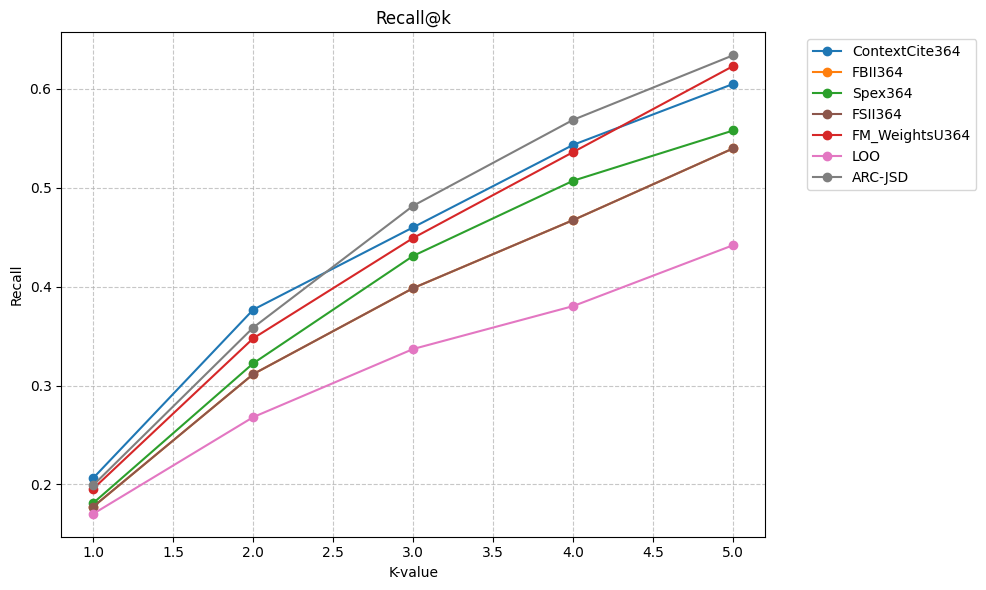

In [61]:
df = recall_res.copy()
plt.figure(figsize=(10,6))

colors = {
    'ContextCite364': '#1f77b4',  
    'FBII364': '#ff7f0e',        
    'Spex364': '#2ca02c',        
    'FSII364':   '#8c564b',    
    'FM_WeightsKS364': '#9467bd', 
    'FM_WeightsU364': '#d62728',  
    'LOO': '#e377c2',            
    'ARC-JSD': '#7f7f7f'         
}

for col in df.columns: 
    if col != 'FM_WeightsKS364':
        plt.plot(df.index, df[col], label = col, color = colors[col], marker='o')

plt.xlabel('K-value')
plt.ylabel('Recall')
plt.title('Recall@k')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, linestyle='--', alpha = 0.7)

plt.tight_layout()
plt.show()


### TopK-Prob/Div

In [64]:
metric = 'topk_probability'
topk_drop = {method :{k:[] for k in method_data.keys()} for method, method_data in eval(df_sample.topk_probability.loc[0])[0][0].items()}
methods = eval(df_sample.topk_probability.loc[0])[0][0].keys()
k_values = [1,2,3,4,5]
for i in df_sample.index: 
    for method in methods : 
        for k in k_values: 
            results = eval(df_sample[metric].loc[i])
            while len(results) == 1:
                results = results[0]
            topk_drop[method][k].append(results[method][k])

topk_drop = {method: {k:round(np.mean(v), 4) for k,v in method_data.items()} for method,method_data in topk_drop.items()}
df_res = pd.DataFrame.from_dict(topk_drop, orient = 'index').T

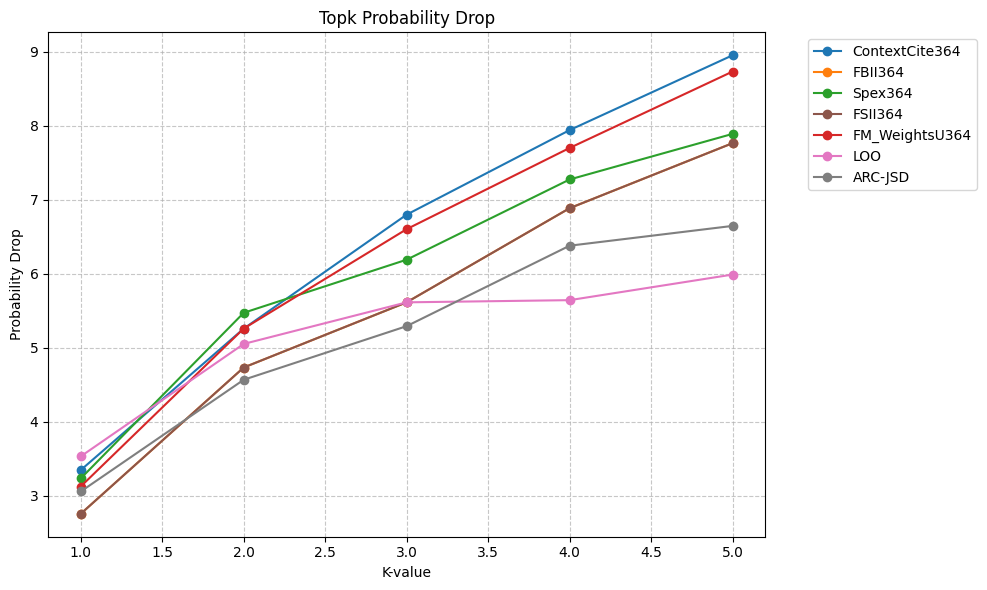

In [65]:
df = df_res.copy()
plt.figure(figsize=(10,6))
y_label = "Probability Drop" if metric == 'topk_probability' else "Divergence Climb"

colors = {
    'ContextCite364': '#1f77b4',  
    'FBII364': '#ff7f0e',        
    'Spex364': '#2ca02c',        
    'FSII364':   '#8c564b',    
    'FM_WeightsKS364': '#9467bd', 
    'FM_WeightsU364': '#d62728',  
    'LOO': '#e377c2',            
    'ARC-JSD': '#7f7f7f'         
}

for col in df.columns: 
    if col != 'FM_WeightsKS364':
        plt.plot(df.index, df[col], label = col, marker='o', color = colors[col])

plt.xlabel('K-value')
plt.ylabel(y_label)
plt.title(f'Topk {y_label}')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, linestyle='--', alpha = 0.7)

plt.tight_layout()
plt.show()
